In [1]:
import numpy as np
import tensorflow as tf
import string
import pandas as pd
import gensim
from datasets import Dataset
from unidecode import unidecode
import spacy
import core.model_utils as model_utils
import core.constants as constants
import matplotlib.pyplot as plt
import os

In [2]:
# Needs to be used to download spacy model for Polish
# !python -m spacy download pl_core_news_sm

In [3]:
# spacy_model = spacy.load("pl_core_news_sm")
#
# # Stop words
# stop_words = spacy_model.Defaults.stop_words.copy()
#
# # Punctuation
# punctuations = string.punctuation
#
#
# # Tokenizer
# def spacy_tokenizer(sentence):
#     doc = spacy_model(sentence)
#
#     # Lemmatizing each token and converting each token into lowercase
#     my_tokens = [ word.lemma_.lower().strip() for word in doc ]
#
#     # Removing stop words and punctuation
#     my_tokens = [ unidecode(word) for word in my_tokens if word not in stop_words and word not in punctuations ]
#     return my_tokens
#
#
# df = pd.read_json('./../data/polish_translated/sarcasm/sarcasm_headlines_dataset_pl.json')
# df = df.drop(columns=['headline', 'article_link'])
# df['tokens'] = df['headline_pl'].apply(spacy_tokenizer)
# df['joined_tokens'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))
# df.to_json('./../data/polish_translated/sarcasm/sarcasm_headlines_dataset_pl_with_tokens_no_diacritics.json')

In [4]:
tokenized_sentences_df = pd.read_json('./../data/polish_translated/sarcasm/sarcasm_headlines_dataset_pl_with_tokens_no_diacritics.json')
tokenized_sentences_df

,is_sarcastic,headline_pl,tokens,joined_tokens
0,1,Naukowcy z lat trzydziestych odkrywają zegar z...,"[naukowiec, rok, trzydziesty, odkrywac, zegar,...",naukowiec rok trzydziesty odkrywac zegar zagla...
1,0,"Reprezentantka rządu USA wyjaśnia, dlaczego Ko...","[reprezentantek, rzad, usa, wyjasniac, kongres...",reprezentantek rzad usa wyjasniac kongres brak...
2,0,Jedz warzywa: 9 pysznie różnych przepisów,"[jedz, warzywac, 9, pysznie, rozny, przepis]",jedz warzywac 9 pysznie rozny przepis
3,1,Nieprzyjemna pogoda uniemożliwia kłamcy dotarc...,"[nieprzyjemny, pogoda, uniemozliwiac, klamca, ...",nieprzyjemny pogoda uniemozliwiac klamca dotar...
4,1,"matka jest bardzo blisko użycia słowa ""streami...","[matka, blisko, uzyc, slowo, streaming, popraw...",matka blisko uzyc slowo streaming poprawnie
...,...,...,...,...
28614,1,Żydzi świętują Rosh Hashasha czy coś,"[zydzi, swietowac, rosh, hashasha]",zydzi swietowac rosh hashasha
28615,1,Śledczy spraw wewnętrznych rozczarowany spiski...,"[sledczy, sprawa, wewnetrzny, rozczarowac, spi...",sledczy sprawa wewnetrzny rozczarowac spisk is...
28616,0,Najpiękniejsza przemowa akceptacyjna w tym tyg...,"[najpiekniejsza, przemowy, akceptacyjny, tydzi...",najpiekniejsza przemowy akceptacyjny tydzien p...
28617,1,Mars zniszczony przez pałac kosmiczny na orbic...,"[mars, zniszczona, palac, kosmiczny, orbicie, ...",mars zniszczona palac kosmiczny orbicie wrot g...


In [5]:
full_dataset = Dataset.from_pandas(tokenized_sentences_df).remove_columns("__index_level_0__")
full_dataset

Dataset({
    features: ['is_sarcastic', 'headline_pl', 'tokens', 'joined_tokens'],
    num_rows: 28619
})

In [6]:
# Train set: 80%, Validation set: 10%, Test set: 10%
train_dataset, val_dataset, test_dataset = model_utils.split_train_val_test(
    full_dataset,
    train_size=0.8,
    test_size_of_val_test_batch=0.5,
    shuffle=True,
    seed=42)

In [7]:
# Word2Vec
tokenized_sentences = train_dataset['tokens']
w2v_model = gensim.models.Word2Vec(sentences=tokenized_sentences, vector_size=100, window=6, min_count=1)
w2v_model.train(tokenized_sentences, epochs=10, total_examples=len(tokenized_sentences))

(1598079, 1636610)

In [8]:
def tokens_to_vector(tokens):
    vector_size = w2v_model.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in tokens:
        if w in w2v_model.wv:
            ctr += 1
            wv_res += w2v_model.wv[w]
    wv_res = wv_res / ctr
    return wv_res

In [9]:
def tokenize_for_word2vec(sample):
    sample['embeddings'] = [tokens_to_vector(tokens) for tokens in sample['tokens']]
    return sample


train_dataset = train_dataset.map(tokenize_for_word2vec, batched=True)
val_dataset = val_dataset.map(tokenize_for_word2vec, batched=True)
test_dataset = test_dataset.map(tokenize_for_word2vec, batched=True)

Map:   0%|          | 0/22895 [00:00<?, ? examples/s]

Map:   0%|          | 0/2862 [00:00<?, ? examples/s]

Map:   0%|          | 0/2862 [00:00<?, ? examples/s]

In [10]:
columns = ["embeddings"]
label_cols = ["is_sarcastic"]
batch_size = 16

tf_train_dataset = model_utils.convert_to_tf_dataset(train_dataset, columns, label_cols, None, batch_size)
tf_val_dataset = model_utils.convert_to_tf_dataset(val_dataset, columns, label_cols, None, batch_size)
tf_test_dataset = model_utils.convert_to_tf_dataset(test_dataset, columns, label_cols, None, batch_size)

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [11]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

In [12]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [13]:
# Model parameters
training_number = 1
model_name = 'sarcasm_pl_word2vec_sentence_own_no_diacritics'
training_name = f"training_{training_number}"
figures_dir = f"./../documentation/models/{model_name}/figures"
checkpoint_filename_template = "cp-{epoch:04d}.ckpt"
checkpoints_dir = os.path.join(constants.TRAINING_CHECKPOINTS_PATH, model_name, training_name)
checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename_template)

In [14]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
callbacks = [checkpoint_cb, early_stop_cb]

In [15]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=20, callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/20
1431/1431 [==============================] - 4s 2ms/step - loss: 0.6547 - accuracy: 0.5988 - val_loss: 0.6424 - val_accuracy: 0.6240

Epoch 00001: saving model to ./../training_checkpoints\sarcasm_pl_word2vec_sentence_own_no_diacritics\training_1\cp-0001.ckpt
Epoch 2/20
1431/1431 [==============================] - 3s 2ms/step - loss: 0.6388 - accuracy: 0.6258 - val_loss: 0.6357 - val_accuracy: 0.6307

Epoch 00002: saving model to ./../training_checkpoints\sarcasm_pl_word2vec_sentence_own_no_diacritics\training_1\cp-0002.ckpt
Epoch 3/20
1431/1431 [==============================] - 3s 2ms/step - loss: 0.6331 - accuracy: 0.6335 - val_loss: 0.6336 - val_accuracy: 0.6356

Epoch 00003: saving model to ./../training_checkpoints\sarcasm_pl_word2vec_sentence_own_no_diacritics\training_1\cp-0003.ckpt
Epoch 4/20
1431/1431 [==============================] - 3s 2ms/step - loss: 0.6299 - accuracy: 0.6367 - val_loss: 0.6304 - val_accuracy: 0.6359

Epoch 00004: saving model to ./../training

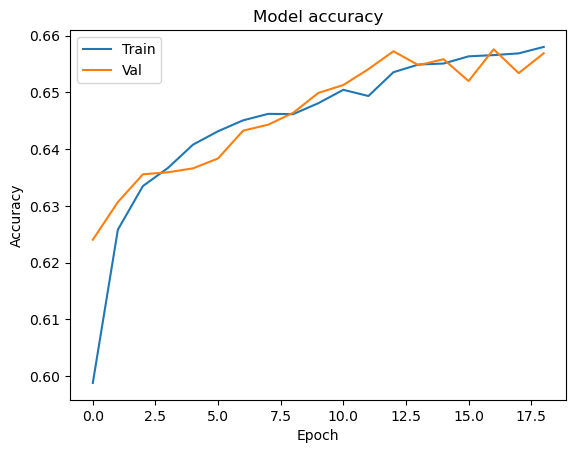

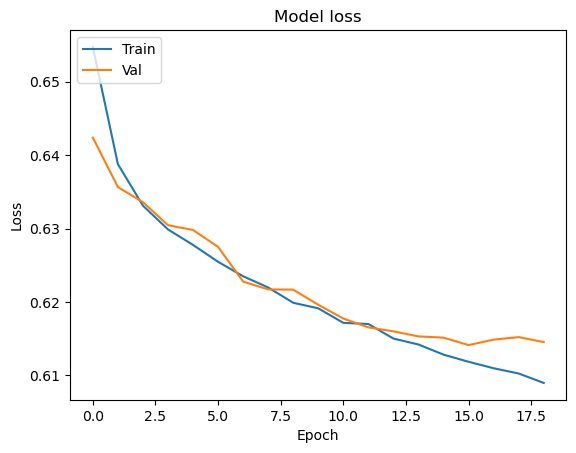

In [16]:
model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['accuracy', 'val_accuracy'],
                                           title='Model accuracy',
                                           y_label='Accuracy',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_accuracy.png")

model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['loss', 'val_loss'],
                                           title='Model loss',
                                           y_label='Loss',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_loss.png")

In [17]:
best_model = model_utils.get_best_model_from_checkpoints(model, history,
                                                         checkpoints_dir=checkpoints_dir,
                                                         checkpoint_filename_template=checkpoint_filename_template)

In [18]:
model_utils.save_model(best_model, model_name=model_name, training_number=training_number, saved_models_dir=constants.SAVED_MODEL_LOCATION, default_model_version=constants.DEFAULT_MODEL_VERSION)

INFO:tensorflow:Assets written to: ./../trained_models\sarcasm_pl_word2vec_sentence_own_no_diacritics_1\1\assets


In [19]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=batch_size)

179/179 [==============================] - 0s 2ms/step - loss: 0.6061 - accuracy: 0.6621


[0.6061344742774963, 0.6621243953704834]

In [20]:
class_preds = model_utils.get_class_preds(best_model, tf_test_dataset, model_returns_logits=False)

In [21]:
precision, recall, f1 = model_utils.get_classification_evaluation_metrics(
    class_actual=test_dataset['is_sarcastic'],
    class_preds=class_preds,
)

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)

Precision score:  0.6685575364667747
Recall score:  0.596529284164859
F1 score:  0.6304929308368361


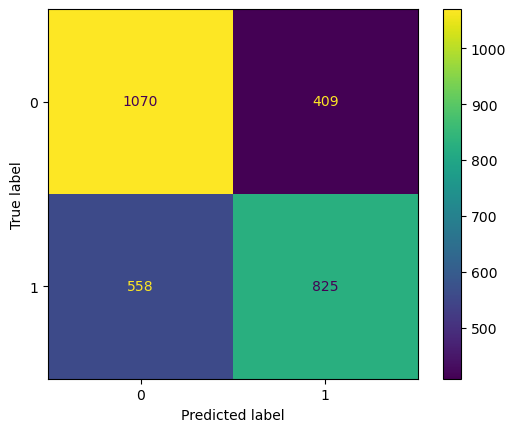

In [22]:
model_utils.plot_and_save_conf_matrix(class_actual=test_dataset['is_sarcastic'],
                                      class_preds=class_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [23]:
model_utils.print_incorrectly_predicted_texts(texts=test_dataset['headline_pl'],
                                              class_actual=test_dataset['is_sarcastic'],
                                              class_preds=class_preds)


            BAD PREDICTION:
            - INDEX: 1
            - TEXT: "New York Times": tyran wybija stos sondaży z rąk Nate'a Silvera
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 3
            - TEXT: hare krishnas: 'hare krishna, hare krishna, krishna krishna, hare hare'
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 5
            - TEXT: najlepsze efekty wizualne Oscar wprowadzony przez wysoko ceniony obiektyw flara
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 8
            - TEXT: Strażnik przy świecach bierze upamiętnienie w swoje ręce
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 10
            - TEXT: Obama odwiedza zniszczoną południową Karolinę
           

In [24]:
test_df = pd.DataFrame(
    list(zip(test_dataset['headline_pl'], test_dataset['is_sarcastic'], class_preds)),
    columns=['headline_pl', 'is_sarcastic', 'prediction'])
test_df

,headline_pl,is_sarcastic,prediction
0,"Szef uważa, że kobieta pracownik może być goto...",1,1
1,"""New York Times"": tyran wybija stos sondaży z ...",1,0
2,"przygotuj się na lizanie w tej przyczepie ""for...",0,0
3,"hare krishnas: 'hare krishna, hare krishna, kr...",1,0
4,Powerball wyciąga plastikowe kulki z solanki z...,1,1
...,...,...,...
2857,Lena Dunham na czerwonym dywanie,0,0
2858,PayPal wycofuje się po tymczasowej globalnej p...,0,1
2859,Naród zrzuca tyrańskie jarzmo umiarkowanego sz...,1,1
2860,Jonathan Rhys Meyers przeprasza za zdjęcia,0,0


In [25]:
def map_token_counts(row):
    return len(row['headline_pl'].split())

def map_count_belonging(row, divider):
    int_division_result = int(row['token_count'] / divider) + 1
    lower_boundary = divider * int_division_result - divider
    upper_boundary = divider * int_division_result - 1
    return f"{lower_boundary}-{upper_boundary}"

def map_correctly_predicted(row):
    return int(row['is_sarcastic'] == row['prediction'])


test_df['token_count'] = test_df.apply(lambda row: map_token_counts(row), axis=1)
test_df['count_belonging'] = test_df.apply(lambda row: map_count_belonging(row, divider=6), axis=1)
test_df['correctly_predicted'] = test_df.apply(lambda row: map_correctly_predicted(row), axis=1)
test_df

,headline_pl,is_sarcastic,prediction,token_count,count_belonging,correctly_predicted
0,"Szef uważa, że kobieta pracownik może być goto...",1,1,16,12-17,1
1,"""New York Times"": tyran wybija stos sondaży z ...",1,0,11,6-11,0
2,"przygotuj się na lizanie w tej przyczepie ""for...",0,0,13,12-17,1
3,"hare krishnas: 'hare krishna, hare krishna, kr...",1,0,10,6-11,0
4,Powerball wyciąga plastikowe kulki z solanki z...,1,1,9,6-11,1
...,...,...,...,...,...,...
2857,Lena Dunham na czerwonym dywanie,0,0,5,0-5,1
2858,PayPal wycofuje się po tymczasowej globalnej p...,0,1,7,6-11,0
2859,Naród zrzuca tyrańskie jarzmo umiarkowanego sz...,1,1,8,6-11,1
2860,Jonathan Rhys Meyers przeprasza za zdjęcia,0,0,6,6-11,1


In [26]:
test_df = test_df.drop(test_df[test_df.token_count > 23].index)

In [27]:
test_df = test_df.sort_values(by=['token_count']).reset_index(drop=True)

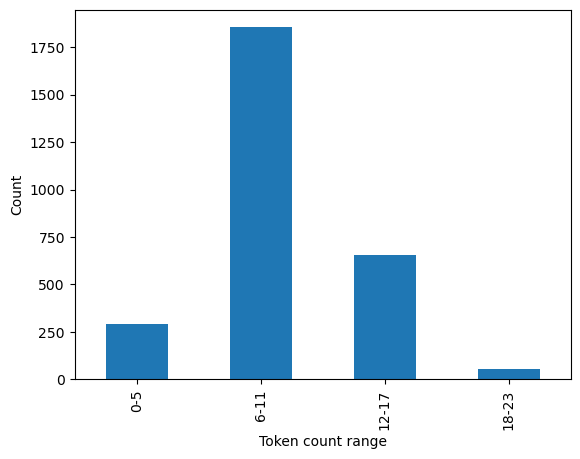

In [28]:
data = test_df['count_belonging']
data.value_counts(sort=False).plot.bar()
plt.xlabel('Token count range')
plt.ylabel('Count')
plt.savefig(os.path.join(figures_dir, f'{training_name}_counts_per_range.png'))
plt.show()

In [29]:
range_to_valid_predictions_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0}
range_to_element_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0}
range_to_pred_accuracy_dict = {'0-5': 0., '6-11': 0., '12-17': 0., '18-23': 0.}

In [30]:
for _, row in test_df.iterrows():
    count_belonging = row['count_belonging']

    range_to_element_count_dict[count_belonging] = range_to_element_count_dict[count_belonging] + 1

    if row['correctly_predicted']:
        range_to_valid_predictions_count_dict[count_belonging] = range_to_valid_predictions_count_dict[count_belonging] + 1

for key in range_to_pred_accuracy_dict.keys():
    range_to_pred_accuracy_dict[key] = range_to_valid_predictions_count_dict[key] / range_to_element_count_dict[key]

print("Correct predictions count: ", range_to_valid_predictions_count_dict)
print("Element count: ", range_to_element_count_dict)
print("Accuracies: ", range_to_pred_accuracy_dict)

Correct predictions count:  {'0-5': 187, '6-11': 1238, '12-17': 436, '18-23': 31}
Element count:  {'0-5': 291, '6-11': 1855, '12-17': 654, '18-23': 57}
Accuracies:  {'0-5': 0.6426116838487973, '6-11': 0.6673854447439354, '12-17': 0.6666666666666666, '18-23': 0.543859649122807}


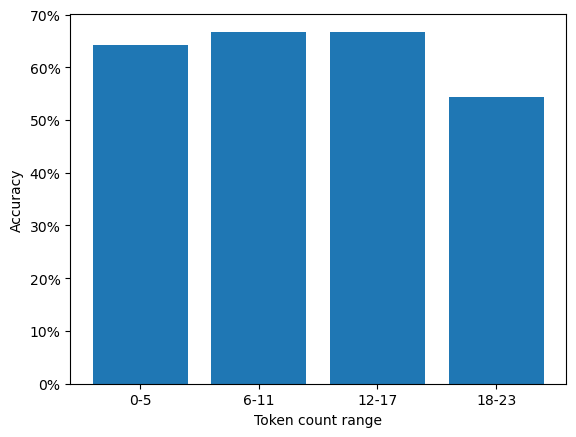

In [31]:
import matplotlib.ticker as mtick

plt.bar(['0-5', '6-11', '12-17', '18-23'], [val for val in range_to_pred_accuracy_dict.values()])
plt.xlabel('Token count range')
plt.ylabel('Accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.savefig(os.path.join(figures_dir, f'{training_name}_accuracies_per_range.png'))
plt.show()